In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing

import japanize_matplotlib

%matplotlib inline


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = lambda_vec[k] *norm.pdf(y)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)
    

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        
        #coef_vec[k] = np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
        
        

    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [3]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

# データの作成

In [28]:
df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
df = df.dropna().reset_index(drop=True)

In [29]:
df.head()

,country,pop,urb,gdp,dist,hf,pf,ef,date_first,detection,status,cumul,air
0,Albania,2866376,60.319,13364.155397,6.996524e+06,7.84,8.005411,7.67,70,74.3,1,108641,303.14
1,Algeria,42228429,72.629,15481.787620,9.108277e+06,4.99,5.201489,4.77,58,12.0,1,80272,6442.44
2,Angola,30809762,65.514,6452.355165,1.049012e+07,5.40,5.979936,4.83,83,17.9,1,303691,76.94
3,Argentina,44494502,91.870,20610.568550,1.902562e+07,6.86,8.044600,5.67,65,74.9,1,92122,1516.63
4,Australia,24992369,86.012,51663.365095,7.608913e+06,8.62,9.160533,8.07,26,97.3,1,1347,75667.65


# config

In [71]:
#FEATS = ["Intercept", "hf", "pop",  "dist", "air"]
FEATS = ["Intercept", "hf", "pop",  "dist", "air"]

### スケーリング(標準化)

In [72]:
sscaler = preprocessing.StandardScaler() # インスタンスの作成

sscaler.fit(df[FEATS[1:]])           # xの平均と分散を計算
X = sscaler.transform(df[FEATS[1:]]) # xを変換



In [73]:
y=df["date_first"].values
X = np.insert(X, 0, 1, axis=1)
pd.DataFrame(X, columns=FEATS)


,Intercept,hf,pop,dist,air
0,1.0,0.857976,-0.309387,-0.358821,-0.297413
1,1.0,-1.762477,0.021782,0.169300,-0.219741
2,1.0,-1.385500,-0.074288,0.514881,-0.300275
3,1.0,-0.043092,0.040847,2.649498,-0.282060
4,1.0,1.575153,-0.123232,-0.205671,0.656070
...,...,...,...,...,...
145,1.0,-2.856631,-0.090606,1.657264,-0.274202
146,1.0,-0.567183,0.470316,-1.553198,0.294006
147,1.0,-2.396903,-0.093732,-0.614905,-0.296993
148,1.0,-0.383291,-0.187515,0.313666,-0.301136


(array([0.0030303 , 0.01060606, 0.00378788, 0.00075758, 0.00530303,
        0.03181818, 0.02651515, 0.025     , 0.00530303, 0.00151515]),
 array([ 14. ,  22.8,  31.6,  40.4,  49.2,  58. ,  66.8,  75.6,  84.4,
         93.2, 102. ]),
 <a list of 10 Patch objects>)

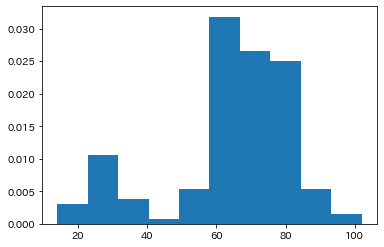

In [74]:
plt.hist(y, density=True)



# 初期値の設定  
- Rで計算済み

In [75]:
# 早期感染国のβ
#coef1_first = [21.790, 0.994, 0.000, -0.014, 0.000, 0.000, 0.000, -0.124]
coef1_first = [34.602, -1.438, 0.747, 6.903, -1.576]

# 晩期感染国のβ
#coef2_first = [93.920, -0.915, 0.000, -0.213, 0.000, 0.000, 0.000, -0.116]
coef2_first = [68.280, -3.843, -6.508, 1.913, -3.199]


first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=FEATS)
first_df["晩期感染国β(初期値)"] = coef2_first
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,34.602,68.280
hf,-1.438,-3.843
pop,0.747,-6.508
dist,6.903,1.913
air,-1.576,-3.199


### sigmaの初期値設定方法は要検討

In [76]:
# muの初期値の計算
# mu = βx
mu1_first = np.mean(X@coef1_first)
mu2_first = np.mean(X@coef2_first)

# データを早期、晩期に分割
y_early = df["date_first"][df["date_first"]<40]
y_late = df["date_first"][df["date_first"]>40]

# sigmaの初期値
sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)


In [77]:

len(y_early)



23

In [78]:
len(y_late)



127

Text(0.5, 1.0, '早期感染国、晩期感染国の数')

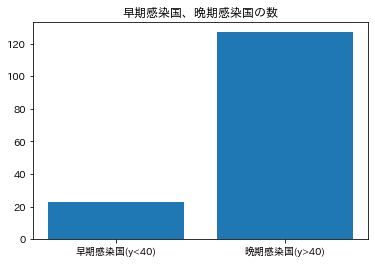

In [79]:
plt.bar( [1, 2], [len(y_early), len(y_late)], tick_label=["早期感染国(y<40)", "晩期感染国(y>40)"], align="center")
plt.title("早期感染国、晩期感染国の数")



In [80]:
# 混合正規分布の数
k_size = 2

# 混合比率
lambda_vec=[0.15, 0.85]

# 説明変数のパラメータ
mu_vec = [mu1_first, mu2_first]

# 分散(sigma)の初期値
sigma2_vec=[sigma1_first, sigma2_first]

# coefの初期値
coef_vec = [coef1_first, coef2_first]

In [81]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1：", sigma2_vec[0])

f1の混合比率： 0.15
mu1： 34.602
sigma1： 27.16824196597353


In [82]:
print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f2の混合比率： 0.85
mu2： 68.28
sigma2： 100.76979353958708


### 初期値から生成される分布の確認

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


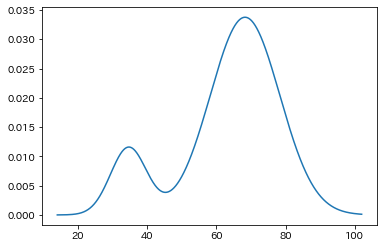

In [83]:
# データ(-6から6までを200こ)
x = sp.linspace(np.min(y), np.max(y), 10000)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

# EMアルゴリズム

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and

i: 0 lambda [0.1539 0.8461] mu [35.6197 68.2868] sigma2 [ 96.7299 105.3376]
i: 10 lambda [0.3763 0.6237] mu [60.1467 67.8402] sigma2 [655.6665  72.1657]
i: 20 lambda [0.4039 0.5961] mu [60.499  67.8068] sigma2 [630.5035  69.6079]
i: 30 lambda [0.4063 0.5937] mu [60.5266 67.8043] sigma2 [628.4028  69.4102]
i: 40 lambda [0.4065 0.5935] mu [60.529  67.8041] sigma2 [628.2169  69.3928]
i: 50 lambda [0.4065 0.5935] mu [60.5292 67.8041] sigma2 [628.2003  69.3912]
i: 60 lambda [0.4065 0.5935] mu [60.5292 67.8041] sigma2 [628.1988  69.3911]
i: 70 lambda [0.4065 0.5935] mu [60.5292 67.8041] sigma2 [628.1987  69.3911]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 80 lambda [0.4065 0.5935] mu [60.5292 67.8041] sigma2 [628.1987  69.3911]
i: 90 lambda [0.4065 0.5935] mu [60.5292 67.8041] sigma2 [628.1987  69.3911]
i: 100 lambda [0.4065 0.5935] mu [60.5292 67.8041] sigma2 [628.1987  69.3911]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

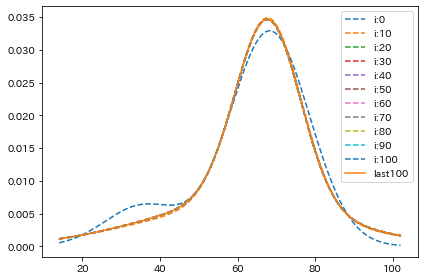

In [84]:
# 100回繰り返す
for i in sp.arange(100+1):
    # Estep
    # responsibilityの更新 
    # responsibility = EStep(k_size, y, lambda_vec, mu_vec, sigma2_vec)
    responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec)
    
    # Mstep
    # 混合割合, 平均, 分散の更新
    lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y)
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
    
    if i % 10 == 0:
        print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
        plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"i:{i}", linestyle="--")
        
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label=f"last{i}", linestyle="-")

plt.legend()
plt.tight_layout()
plt.show()

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


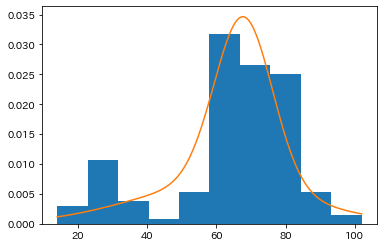

In [85]:
plt.hist(y, density=True)
plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec), label="ini")

#### 注  
- mu1, mu2は反転する可能性があるため、f1, f2の混合比率を確認

In [20]:
print("f1の混合比率：", lambda_vec[0])
print("mu1：", mu_vec[0])
print("sigma1", sigma2_vec[0])

print("f2の混合比率：", lambda_vec[1])
print("mu2：", mu_vec[1])
print("sigma2：", sigma2_vec[1])

f1の混合比率： 0.4014115457244783
mu1： 60.74210961260852
sigma1 630.4333586395846
f2の混合比率： 0.5985884542755218
mu2： 68.40835778116642
sigma2： 68.99089325445806


###  推定された分布の可視化

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  This is separate from the ipykernel package so we can avoid doing imports until


(array([5.01355879e-05, 1.35366087e-03, 8.39771098e-03, 2.66470650e-02,
        4.62500799e-02, 4.01335381e-02, 2.06307944e-02, 5.89093158e-03,
        5.76559261e-04, 1.00271176e-04]),
 array([ 35.97806067,  42.64336109,  49.30866151,  55.97396192,
         62.63926234,  69.30456276,  75.96986318,  82.6351636 ,
         89.30046402,  95.96576444, 102.63106486]),
 <a list of 10 Patch objects>)

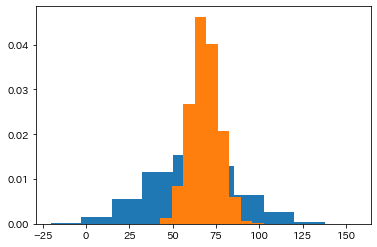

In [21]:
# 推定された分布の可視化
new_N1 = stats.norm(loc=mu_vec[0], scale=sp.sqrt(sigma2_vec[0]))
new_N2 = stats.norm(loc=mu_vec[1], scale=sp.sqrt(sigma2_vec[1]))

# rvs (Random variates) 確率変数
new_s1 = new_N1.rvs(size=int(lambda_vec[0]*10000))
new_s2 = new_N2.rvs(size=int(lambda_vec[1]*10000))


#plt.hist(y, bins=30, density=True)

plt.hist(new_s1, density=True)
plt.hist(new_s2, density=True)


### # 推定されたパラメータ

In [22]:
res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept", "hf", "pop",  "urb", "gdp","dist", "air", "detection"], columns=["早期感染国"])
res_df["晩期感染国"] = coef_vec[1].round(4)
res_df

,早期感染国,晩期感染国
Intercept,60.7421,68.4084
hf,-2.5841,-0.9461
pop,-1.9335,-6.6829
urb,-3.0939,-3.9462
gdp,-1.9790,-1.5183
dist,10.8650,1.4737
air,-1.9872,3.0226
detection,-7.2403,-2.0241


In [23]:
# 初期値パラメータ
first_df

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,21.790,93.920
hf,0.994,-0.915
pop,0.000,0.000
urb,-0.014,-0.213
gdp,0.000,0.000
dist,0.000,0.000
air,0.000,0.000
detection,-0.124,-0.116


# 改善事項  
- p値  
- 信頼区間  
- AIC  
  
  
- 対数化しない場合  
- 変数選択  
- f1とf2で変数を帰る